# GP

In [1]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
#%matplotlib widget


# Setup environment collect data

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="rgb_array")

In [294]:
# === Cell Z — Save MountainCar dataset for GP analysis ===
import numpy as np, json, time

def save_mc_dataset(path,
                    pos, vel, act, dpos, dvel,
                    episode_id=None, step_id=None,
                    meta=None):
    """
    Saves a clean NPZ with all signals needed to analyze/fit the GP dynamics.

    Required 1D arrays (same length): pos, vel, act, dpos, dvel
      - pos, vel: state at time t
      - act: action a_t applied
      - dpos, dvel: next_state - state  (i.e., Δpos, Δvel)

    Optional:
      - episode_id: int per-sample episode index
      - step_id:    int per-sample step index within episode
      - meta: dict with any extra info (seed, horizons, etc.)

    Output NPZ keys:
      'pos','vel','act','dpos','dvel' (+ 'ep_id','step_id' if provided)
      'meta_json' (JSON string with metadata)
    """
    # to float32, flat, equal length
    pos  = np.asarray(pos,  np.float32).reshape(-1)
    vel  = np.asarray(vel,  np.float32).reshape(-1)
    act  = np.asarray(act,  np.float32).reshape(-1)
    dpos = np.asarray(dpos, np.float32).reshape(-1)
    dvel = np.asarray(dvel, np.float32).reshape(-1)

    n = min(pos.size, vel.size, act.size, dpos.size, dvel.size)
    pos, vel, act, dpos, dvel = pos[:n], vel[:n], act[:n], dpos[:n], dvel[:n]

    out = {
        "pos":  pos,
        "vel":  vel,
        "act":  act,
        "dpos": dpos,
        "dvel": dvel,
    }

    if episode_id is not None:
        out["ep_id"] = np.asarray(episode_id, np.int32).reshape(-1)[:n]
    if step_id is not None:
        out["step_id"] = np.asarray(step_id, np.int32).reshape(-1)[:n]

    meta = {} if meta is None else dict(meta)
    meta.setdefault("created_utc", int(time.time()))
    meta.setdefault("env", "MountainCarContinuous-v0")
    out["meta_json"] = np.array([json.dumps(meta)], dtype=object)

    np.savez_compressed(path, **out)
    print(f"Saved {path}  |  N={n}  |  keys={list(out.keys())}")

# ---- Example usage (run after your collection code) ----
# save_mc_dataset("mc_dataset_user_v1.npz", pos, vel, act, dpos, dvel)

# Optional: quick sanity check after saving
# D = np.load("mc_dataset_user_v1.npz", allow_pickle=True)
# print({k: D[k].shape for k in D.files})
# print("meta:", D["meta_json"][0])


# Dynamics from GP

Saved mc_cov_v1.npz  |  N=1000  |  keys=['pos', 'vel', 'act', 'dpos', 'dvel', 'meta_json']
dataset shapes: (1000,) (1000,) (1000,) (1000,) (1000,)
nonempty bins: 458 / 1225


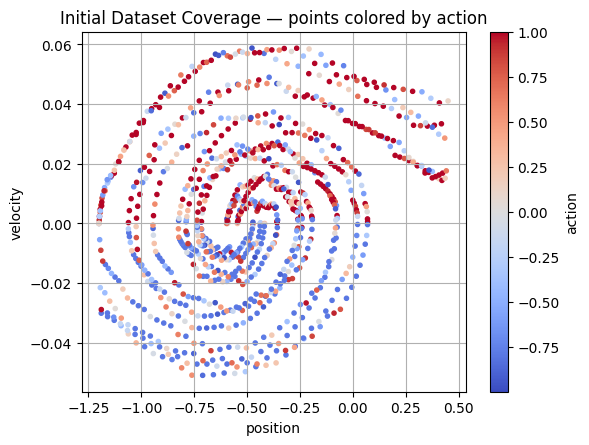

In [295]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Sobol low-discrepancy sequence for actions (falls back to uniform random if unavailable)
try:
    from scipy.stats import qmc
    _HAS_QMC = True
except Exception:
    _HAS_QMC = False

SEED = 0

class SobolActions:
    """Generate low-discrepancy action samples in [-1, 1]."""
    def __init__(self, low=-1.0, high=1.0, scramble=True, seed=SEED):
        self.low, self.high = float(low), float(high)
        self.rng = np.random.default_rng(seed)
        if _HAS_QMC:
            self._eng = qmc.Sobol(d=1, scramble=scramble, seed=seed)
        else:
            self._eng = None
        self._buf = np.empty((0, 1), np.float32)
    def next(self, n=1):
        if self._eng is None:
            u = self.rng.random((n, 1), dtype=np.float32)  # uniform [0,1]
        else:
            u = self._eng.random(n).astype(np.float32)      # Sobol [0,1]
        a = self.low + (self.high - self.low) * u
        return a.reshape(-1)

def swing_up_policy(obs, action_space):
    """Swing-up heuristic: push in direction of velocity, with a slight bias rightwards."""
    p, v = float(obs[0]), float(obs[1])
    a = 0.9 * np.sign(v) + 0.1  # bias towards right
    low, high = action_space.low.item(), action_space.high.item()
    return np.array([np.clip(a, low, high)], dtype=np.float32)

def random_policy(action_space, rng):
    low, high = action_space.low.item(), action_space.high.item()
    return np.array([rng.uniform(low, high)], dtype=np.float32)

def collect_coverage(n_steps=1000, bins_pos=35, bins_vel=35,
                     cap_per_bin=40, keep_prob_after_cap=0.05,
                     sobol_ratio=0.5, swing_ratio=0.4, random_ratio=0.1,
                     seed=SEED):
    assert abs(sobol_ratio + swing_ratio + random_ratio - 1.0) < 1e-9
    rng = np.random.default_rng(seed)
    env = gym.make("MountainCarContinuous-v0")
    obs, _ = env.reset(seed=seed)
    low_a, high_a = env.action_space.low.item(), env.action_space.high.item()
    sobol = SobolActions(low=low_a, high=high_a, seed=seed)
    # Initialize bin grid for position and velocity
    pos_lo, pos_hi = env.observation_space.low[0], env.observation_space.high[0]
    vel_lo, vel_hi = env.observation_space.low[1], env.observation_space.high[1]
    pos_edges = np.linspace(pos_lo, pos_hi, bins_pos+1)
    vel_edges = np.linspace(vel_lo, vel_hi, bins_vel+1)
    counts = np.zeros((bins_pos, bins_vel), dtype=np.int32)
    # Storage lists
    pos_list, vel_list, act_list = [], [], []
    dpos_list, dvel_list = [], []
    def bin_index(p, v):
        i = np.searchsorted(pos_edges, p, side="right") - 1
        j = np.searchsorted(vel_edges, v, side="right") - 1
        i = np.clip(i, 0, bins_pos-1)
        j = np.clip(j, 0, bins_vel-1)
        return i, j

    for t in range(n_steps):
        # Choose action source according to fixed probabilities
        r = rng.random()
        if r < sobol_ratio:
            a = np.array([sobol.next(1)[0]], dtype=np.float32)
        elif r < sobol_ratio + swing_ratio:
            a = swing_up_policy(obs, env.action_space)
        else:
            a = random_policy(env.action_space, rng)
        nxt, _, term, trunc, _ = env.step(a)
        # Current state and transition
        p, v = float(obs[0]), float(obs[1])
        dp, dv = float(nxt[0] - obs[0]), float(nxt[1] - obs[1])
        i, j = bin_index(p, v)
        # Log this sample if bin not full (or with small probability if full)
        if counts[i, j] < cap_per_bin or rng.random() < keep_prob_after_cap:
            pos_list.append(p); vel_list.append(v); act_list.append(float(a[0]))
            dpos_list.append(dp); dvel_list.append(dv)
            counts[i, j] += 1
        # Reset environment on episode end to continue gathering transitions
        obs = nxt
        if term or trunc:
            obs, _ = env.reset()
    env.close()
    pos_arr = np.array(pos_list, dtype=np.float32)
    vel_arr = np.array(vel_list, dtype=np.float32)
    act_arr = np.array(act_list, dtype=np.float32)
    dpos_arr = np.array(dpos_list, dtype=np.float32)
    dvel_arr = np.array(dvel_list, dtype=np.float32)
    return pos_arr, vel_arr, act_arr, dpos_arr, dvel_arr, counts, (pos_edges, vel_edges)

# Run data collection for 1000 steps
pos, vel, act, dpos, dvel, counts, (pos_edges, vel_edges) = collect_coverage(n_steps=1000, seed=SEED)

save_mc_dataset("mc_cov_v1.npz", pos, vel, act, dpos, dvel,
                meta={"source":"coverage","sobol_ratio":0.5})

print("dataset shapes:", pos.shape, vel.shape, act.shape, dpos.shape, dvel.shape)
print("nonempty bins:", (counts > 0).sum(), "/", counts.size)

# Plot the collected state-space coverage, coloring points by action value
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.12, 0.12, 0.6, 0.6])
norm = TwoSlopeNorm(vcenter=0.0, vmin=act.min(), vmax=act.max())
pts = ax.scatter(pos, vel, c=act, s=9, cmap="coolwarm", norm=norm)
ax.set_xlabel("position"); ax.set_ylabel("velocity")
ax.set_title("Initial Dataset Coverage — points colored by action")
cb = plt.colorbar(pts, ax=ax)
cb.set_label("action")
ax.grid(True)
plt.show()


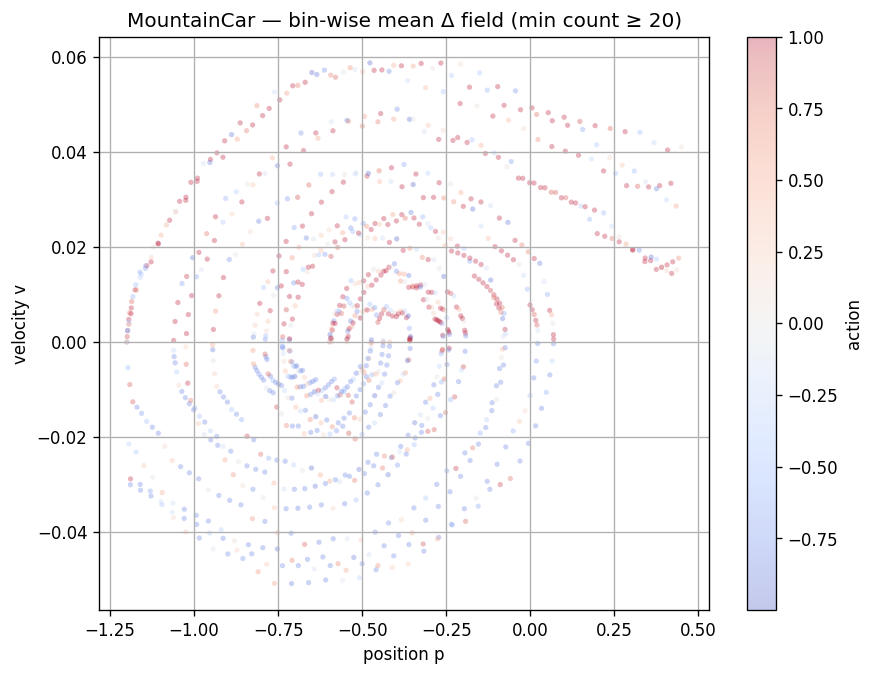

Covered bins (≥20 samples): 0/1225  (0.0%)


In [296]:
# =========================
# Cell G1 — Bin-wise quiver
# =========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ---- inputs expected in the notebook scope ----
# pos, vel, act, dpos, dvel : 1D np.arrays from your collector
# (If you used 'collect' already, they're in scope.)

# ---- knobs ----
BINS_POS = 35
BINS_VEL = 35
MIN_COUNT = 20        # require at least this many samples per bin
ARROW_STRIDE = 2      # skip every N bins to declutter arrows
SCATTER_SUBSAMPLE = 1 # e.g., 3 to plot fewer points for speed (1 = keep all)

def _bin_edges_and_centers(xmin, xmax, n):
    edges = np.linspace(xmin, xmax, n+1)
    ctrs  = 0.5*(edges[:-1] + edges[1:])
    return edges, ctrs

def make_bin_stats(pos, vel, dpos, dvel, bins_pos=35, bins_vel=35, min_count=10):
    pe, pc = _bin_edges_and_centers(pos.min(), pos.max(), bins_pos)
    ve, vc = _bin_edges_and_centers(vel.min(), vel.max(), bins_vel)
    # indices
    ii = np.clip(np.digitize(pos, pe)-1, 0, bins_pos-1)
    jj = np.clip(np.digitize(vel, ve)-1, 0, bins_vel-1)

    # accumulators
    C   = np.zeros((bins_pos, bins_vel), dtype=np.int32)
    Sdp = np.zeros_like(C, dtype=np.float64)
    Sdv = np.zeros_like(C, dtype=np.float64)

    for k in range(pos.shape[0]):
        i, j = ii[k], jj[k]
        C[i, j]   += 1
        Sdp[i, j] += dpos[k]
        Sdv[i, j] += dvel[k]

    with np.errstate(invalid='ignore', divide='ignore'):
        Mdp = Sdp / np.maximum(C, 1)  # mean Δp per bin
        Mdv = Sdv / np.maximum(C, 1)  # mean Δv per bin

    mask = C >= min_count
    return pc, vc, Mdp, Mdv, C, mask

pc, vc, Mdp, Mdv, C, mask = make_bin_stats(pos, vel, dpos, dvel,
                                           bins_pos=BINS_POS, bins_vel=BINS_VEL,
                                           min_count=MIN_COUNT)

# grid for quiver (subsample + mask)
I = slice(None, None, ARROW_STRIDE)
J = slice(None, None, ARROW_STRIDE)
Pc, Vc = np.meshgrid(pc, vc, indexing="ij")
Xq = Pc[I, J]
Yq = Vc[I, J]
Uq = np.where(mask[I, J], Mdp[I, J], np.nan)
Vq = np.where(mask[I, J], Mdv[I, J], np.nan)

# figure
fig, ax = plt.subplots(figsize=(8.2, 6.2), dpi=120)

# scatter of raw (p,v) colored by action (centered at 0)
idx = slice(None, None, SCATTER_SUBSAMPLE)
norm = TwoSlopeNorm(vcenter=0.0, vmin=float(np.min(act)), vmax=float(np.max(act)))
pts = ax.scatter(pos[idx], vel[idx], c=act[idx], s=10, alpha=0.3, cmap="coolwarm", norm=norm, edgecolors='none')

# quiver of mean Δ (scale units in state-space)
# scale=None lets Matplotlib auto-scale; tweak 'scale' to shrink/grow arrows globally
Q = ax.quiver(Xq, Yq, Uq, Vq, angles='xy', scale_units='xy', scale=1.0, width=0.0025, alpha=0.9)

cb = plt.colorbar(pts, ax=ax); cb.set_label("action")
ax.set_xlabel("position p"); ax.set_ylabel("velocity v")
ax.set_title(f"MountainCar — bin-wise mean Δ field (min count ≥ {MIN_COUNT})")
ax.grid(True)
plt.show()

# (Optional) quick coverage printout
covered = int(np.count_nonzero(mask))
total_bins = BINS_POS*BINS_VEL
print(f"Covered bins (≥{MIN_COUNT} samples): {covered}/{total_bins}  ({100*covered/total_bins:.1f}%)")


# GP MODEL NEW

# CELL A

In [297]:
import numpy as np, torch, gpytorch
device = torch.device("cuda")

# You already have these from your rollouts:
# pos, vel, act, dpos, dvel  (all 1D numpy arrays of equal length)
# If they are Python lists, np.asarray(...) is fine.

X_np = np.column_stack([pos, vel, act]).astype(np.float32)   # (N,3)
Y_np = np.column_stack([dpos, dvel]).astype(np.float32)      # (N,2)

Xtr  = torch.tensor(X_np, device=device)
Ytr  = torch.tensor(Y_np, device=device)

# Per-dimension standardization (inputs & outputs)
X_mu, X_std = Xtr.mean(0), Xtr.std(0).clamp_min(1e-6)
Y_mu, Y_std = Ytr.mean(0), Ytr.std(0).clamp_min(1e-6)

Xz = (Xtr - X_mu) / X_std              # (N,3)
Yz = (Ytr - Y_mu) / Y_std              # (N,2)

N = Xz.shape[0]
print("N =", N, "| Xz:", Xz.shape, "| Yz:", Yz.shape, "| device:", device)


N = 1000 | Xz: torch.Size([1000, 3]) | Yz: torch.Size([1000, 2]) | device: cuda


In [298]:
# === Cell A+ (freeze normalization for AL rounds) ===
X_mu0 = X_mu.detach().clone()
X_std0 = X_std.detach().clone()
Y_mu0 = Y_mu.detach().clone()
Y_std0 = Y_std.detach().clone()

def z_inputs(X_np):
    Xb = torch.tensor(X_np, device=device)
    return (Xb - X_mu0) / X_std0

def z_targets(Y_np):
    Yb = torch.tensor(Y_np, device=device)
    return (Yb - Y_mu0) / Y_std0


# CELL B

In [299]:
import math
from gpytorch.variational import (
    VariationalStrategy, CholeskyVariationalDistribution, LMCVariationalStrategy
)

num_tasks   = 2      # Δpos, Δvel
num_latents = 2      # latent GPs in LMC head (tune: 1–3)
M           = 128    # inducing points (tune: 64–512)

# Simple grid of inducing points in standardized space (you can KMeans instead)
with torch.no_grad():
    mins = Xz.min(0).values
    maxs = Xz.max(0).values
    g0 = torch.linspace(mins[0], maxs[0], int(M**(1/3))+2, device=device)
    g1 = torch.linspace(mins[1], maxs[1], int(M**(1/3))+2, device=device)
    g2 = torch.linspace(mins[2], maxs[2], int(M**(1/3))+2, device=device)
    G  = torch.stack(torch.meshgrid(g0, g1, g2, indexing="ij"), dim=-1).reshape(-1,3)
    inducing_points = G[torch.linspace(0, len(G)-1, M).round().long()].contiguous()  # (M,3)

# Model
class LMC_MTSVGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_latents=2, num_tasks=2):
        # batch over latents: (Q, M, D)
        inducing_points = inducing_points.unsqueeze(0).expand(num_latents, -1, -1)
        q_u = CholeskyVariationalDistribution(
            inducing_points.size(-2),
            batch_shape=torch.Size([num_latents])
        )
        base_vs = VariationalStrategy(
            self, inducing_points, q_u, learn_inducing_locations=True
        )
        lmc_vs = LMCVariationalStrategy(
            base_vs, num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1
        )
        super().__init__(lmc_vs)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = LMC_MTSVGP(inducing_points.to(device), num_latents=num_latents, num_tasks=num_tasks).to(device)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, "M params (approx)")


0.033802 M params (approx)


# CELL C

In [300]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [301]:
import tqdm

model.train(); likelihood.train()

opt = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 0.08},
    {'params': likelihood.parameters(), 'lr': 0.05},
])

# Variational ELBO needs num_data for minibatches; here we do full-batch
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Yz.size(0))

E = 800   # epochs
pbar = tqdm.tqdm(range(E))
for e in pbar:
    opt.zero_grad()
    out = model(Xz)
    loss = -mll(out, Yz)
    loss.backward()
    opt.step()

    if (e+1) % 100 == 0:
        # Report per-task lengthscales / noise
        ls = model.covar_module.base_kernel.lengthscale.detach().view(-1).mean().item()
        noise = likelihood.task_noises.detach().mean().item() if hasattr(likelihood, "task_noises") else float('nan')
        pbar.set_description(f"ELBO {loss.item():.3f} | ls~{ls:.3f} | noise~{noise:.4f}")

model.eval(); likelihood.eval()


ELBO -1.068 | ls~1.798 | noise~0.1044: 100%|██████████| 800/800 [00:04<00:00, 164.28it/s]


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

# CELL D

In [302]:
@torch.no_grad()
def gp_predict_delta(pos_batch, vel_batch, act_batch, sample=False):
    """
    Inputs: 1D numpy or torch, same length (B,)
    Returns:
      mean_dpos, mean_dvel, std_dpos, std_dvel  (np arrays)
      If sample=True, also returns one sampled (dpos, dvel) draw via rsample().
    """
    if not torch.is_tensor(pos_batch):
        Xb = torch.tensor(np.column_stack([pos_batch, vel_batch, act_batch]),
                          dtype=torch.float32, device=device)
    else:
        Xb = torch.stack([pos_batch, vel_batch, act_batch], dim=-1).to(device).float()
    Xb_z = (Xb - X_mu) / X_std

    model.eval(); likelihood.eval()
    with gpytorch.settings.fast_pred_var():
        pred = likelihood(model(Xb_z))  # MultitaskMultivariateNormal with 2 outputs
        mean = pred.mean                # (B, 2)
        var  = pred.variance            # (B, 2)

        # de-standardize
        mean = mean * Y_std + Y_mu
        std  = var.clamp_min(1e-12).sqrt() * Y_std

        m_dp = mean[..., 0].detach().cpu().numpy()
        m_dv = mean[..., 1].detach().cpu().numpy()
        s_dp = std[..., 0].detach().cpu().numpy()
        s_dv = std[..., 1].detach().cpu().numpy()

        if not sample:
            return m_dp, s_dp, m_dv, s_dv

        # one reparameterized sample from the predictive (per point)
        sample_mv = pred.rsample()                     # (B, 2)
        sample_np = (sample_mv * Y_std + Y_mu).detach().cpu().numpy()
        return m_dp, s_dp, m_dv, s_dv, sample_np[:,0], sample_np[:,1]

def gp_step(state_batch, action_batch, dt=1.0, stochastic=False):
    """
    Vectorized one-step model for MPPI:
      state_batch: (B,2) [pos, vel]
      action_batch: (B,) or (B,1)
    Returns next_state mean (B,2) and optionally a sample (B,2) if stochastic=True.
    """
    sb = torch.as_tensor(state_batch, device=device, dtype=torch.float32)
    ab = torch.as_tensor(action_batch, device=device, dtype=torch.float32).view(-1)
    pos_b, vel_b = sb[:,0], sb[:,1]

    if stochastic:
        m_dp, _, m_dv, _, s_dp_samp, s_dv_samp = gp_predict_delta(pos_b, vel_b, ab, sample=True)
        dpos = s_dp_samp; dvel = s_dv_samp
    else:
        m_dp, _, m_dv, _ = gp_predict_delta(pos_b, vel_b, ab, sample=False)
        dpos = m_dp; dvel = m_dv

    nxt = np.stack([pos_b.detach().cpu().numpy() + dpos*dt,
                    vel_b.detach().cpu().numpy() + dvel*dt], axis=-1)
    return nxt


# CELL E

In [303]:
# GP dynamics adapter for MPPI:
# - Expects your trained multitask SVGP "model" and "likelihood"
# - Uses your standardization stats: X_mu, X_std, Y_mu, Y_std  (from Cell A)
# - Provides: step_batch(states, actions, stochastic=False)  -> next_states

import numpy as np
import torch, gpytorch

class SVGPDynamics:
    def __init__(self, model, likelihood, X_mu, X_std, Y_mu, Y_std, device=None):
        self.model = model.eval()
        self.lik   = likelihood.eval()
        self.X_mu  = X_mu
        self.X_std = X_std.clamp_min(1e-6)
        self.Y_mu  = Y_mu
        self.Y_std = Y_std.clamp_min(1e-6)
        self.device = device or next(model.parameters()).device

    @torch.no_grad()
    def _predict_delta(self, Xq):  # Xq: (B,3) tensor on device
        Xqz = (Xq - self.X_mu) / self.X_std
        with gpytorch.settings.fast_pred_var():
            post = self.lik(self.model(Xqz))              # multitask posterior
        mean = post.mean * self.Y_std + self.Y_mu         # (B,2) de-standardized
        var  = post.variance.clamp_min(1e-12) * (self.Y_std**2)
        return mean, var

    @torch.no_grad()
    def step_batch(self, states, actions, stochastic=False, dt=1.0, return_std=False):
        """
        states:  (B,2) [pos, vel]  (np or torch)
        actions: (B,) or (B,1)     (np or torch)
        returns next_states (B,2)  numpy
        """
        if not torch.is_tensor(states):
            S = torch.as_tensor(states,  dtype=torch.float32, device=self.device)
        else:
            S = states.to(self.device).float()
        if not torch.is_tensor(actions):
            A = torch.as_tensor(actions, dtype=torch.float32, device=self.device).view(-1, 1)
        else:
            A = actions.to(self.device).float().view(-1, 1)

        Xq = torch.cat([S, A], dim=1)                     # (B,3)
        mean, var = self._predict_delta(Xq)               # (B,2), (B,2)
        std = var.clamp_min(1e-12).sqrt()                # (B,2)

        if stochastic:
            #std = var.sqrt()
            eps = torch.randn_like(std)
            d = mean + eps * std                          # sampled delta
        else:
            d = mean                                      # mean delta

        S_next = S + d * dt
        if return_std:
            # return scalar magnitude of uncertainty for convenience
            s_mag = (std[...,0]**2 + std[...,1]**2).sqrt().cpu().numpy()
            return S_next.cpu().numpy(), s_mag
        return S_next.cpu().numpy()



In [304]:
# === Cell F — build the GP dynamics adapter to use inside GP_MPPI ===
dyn = SVGPDynamics(
    model, likelihood,      # trained multitask SVGP from Cells B–C
    X_mu, X_std, Y_mu, Y_std,
    device=device
)


# ACTIVE LEARNING

### CELL H1

In [305]:
# ======================================
# Cell H1 — Uncertainty-driven acquisition
# Uses gp_predict_delta(...) already defined in Cells C/D
# ======================================
import numpy as np, gymnasium as gym

def gp_pred_std_mag(p_batch, v_batch, a_batch):
    """Return scalar GP uncertainty magnitude per (p,v,a)."""
    _, s_dp, _, s_dv = gp_predict_delta(p_batch, v_batch, a_batch, sample=False)
    return np.sqrt(s_dp**2 + s_dv**2)


class CandidateSampler:
    def __init__(self, cand=16, seed=0):
        self.cand = int(cand)
        self.rng = np.random.default_rng(seed)
        try:
            from scipy.stats import qmc
            self._sobol = qmc.Sobol(d=1, scramble=True, seed=seed)
        except Exception:
            self._sobol = None
    def sample(self):
        if self._sobol is not None:
            u = self._sobol.random(self.cand).reshape(-1)
            return 2.0*u - 1.0
        else:
            return self.rng.uniform(-1.0, 1.0, size=self.cand)

def swing_up_action(obs):
    p, v = float(obs[0]), float(obs[1])
    return float(np.clip(np.sign(v), -1.0, 1.0))

def acquire_uncertain_transitions(n_steps=3000, cand=24, eps=0.10, mix_swing_prob=0.10, seed=0):
    """
    Collect a batch of transitions by probing actions where the GP model is most uncertain.
    - cand: number of candidate actions to sample at each step for uncertainty evaluation.
    - eps: epsilon-greedy random action probability.
    - mix_swing_prob: probability to force a swing-up action to avoid stalling.
    """
    env = gym.make("MountainCarContinuous-v0")
    obs, _ = env.reset(seed=seed)
    rng = np.random.default_rng(seed)
    sampler = CandidateSampler = SobolActions  # reuse Sobol sampler for candidates
    sampler = sampler(cand=cand, seed=seed) if hasattr(SobolActions, 'sample') else SobolActions(low=-1.0, high=1.0, seed=seed)
    # Note: Above, SobolActions does not have 'cand' attribute in our implementation.
    # We will just sample cand actions using its .next() method if possible.
    # Fallback to uniform if Sobol not available:
    if not _HAS_QMC:
        def candidate_actions():
            return rng.uniform(-1.0, 1.0, size=cand).astype(np.float32)
    else:
        def candidate_actions():
            return sampler.next(cand).astype(np.float32)
    new_pos, new_vel, new_act, new_dpos, new_dvel = [], [], [], [], []
    for _ in range(n_steps):
        p, v = float(obs[0]), float(obs[1])
        # Occasionally apply swing-up action to ensure motion
        if rng.random() < mix_swing_prob:
            a = float(np.clip(np.sign(v), -1.0, 1.0))
        else:
            # Sample candidate actions and pick the one with max predicted uncertainty
            A = candidate_actions()  # array of shape (cand,)
            P = np.full_like(A, p, dtype=np.float32)
            V = np.full_like(A, v, dtype=np.float32)
            sigma = gp_pred_std_mag(P, V, A)  # GP uncertainty for each candidate:contentReference[oaicite:14]{index=14}
            # ε-greedy: with prob eps pick a random action instead of max-uncertainty
            if rng.random() < eps:
                a = float(rng.uniform(-1.0, 1.0))
            else:
                a = float(A[int(np.argmax(sigma))])
        nxt, _, term, trunc, _ = env.step([a])
        # Record transition
        new_pos.append(p); new_vel.append(v); new_act.append(a)
        new_dpos.append(float(nxt[0] - p)); new_dvel.append(float(nxt[1] - v))
        obs = nxt
        if term or trunc:
            obs, _ = env.reset()
    env.close()
    # Return new samples as numpy arrays
    return (np.array(new_pos, dtype=np.float32),
            np.array(new_vel, dtype=np.float32),
            np.array(new_act, dtype=np.float32),
            np.array(new_dpos, dtype=np.float32),
            np.array(new_dvel, dtype=np.float32))


### CELL H2

In [306]:
# ======================================
# Cell H2 — Append + retrain SVGP (warm-start) + refresh dyn
# Requires: model, likelihood, device; SVGPDynamics; Cells A–C and E loaded.
# ======================================
import torch, gpytorch, numpy as np

def append_and_retrain(new_pos, new_vel, new_act, new_dpos, new_dvel, extra_epochs=200, lr_model=0.05, lr_lik=0.03):
    """Append new data to the training set and fine-tune the GP model for a few epochs."""
    global pos, vel, act, dpos, dvel, Xtr, Ytr, X_mu, X_std, Y_mu, Y_std, Xz, Yz, model, likelihood, dyn
    # 1) Append new samples to dataset
    pos  = np.concatenate([pos,  new_pos])
    vel  = np.concatenate([vel,  new_vel])
    act  = np.concatenate([act,  new_act])
    dpos = np.concatenate([dpos, new_dpos])
    dvel = np.concatenate([dvel, new_dvel])
    # 2) Recompute tensors and normalization (use updated dataset)
    X_np = np.column_stack([pos, vel, act]).astype(np.float32)
    Y_np = np.column_stack([dpos, dvel]).astype(np.float32)
    Xtr = torch.tensor(X_np, device=device)
    Ytr = torch.tensor(Y_np, device=device)
    X_mu, X_std = Xtr.mean(0), Xtr.std(0).clamp_min(1e-6)
    Y_mu, Y_std = Ytr.mean(0), Ytr.std(0).clamp_min(1e-6)
    Xz = (Xtr - X_mu) / X_std
    Yz = (Ytr - Y_mu) / Y_std
    # 3) Continue training the GP model (warm-start from current parameters)
    model.train(); likelihood.train()
    opt = torch.optim.Adam([
        {'params': model.parameters(),      'lr': lr_model},
        {'params': likelihood.parameters(), 'lr': lr_lik}
    ])
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Yz.size(0))
    for _ in range(extra_epochs):
        opt.zero_grad()
        out = model(Xz)
        loss = -mll(out, Yz)
        loss.backward()
        opt.step()
    model.eval(); likelihood.eval()
    # 4) Refresh dynamics adapter for MPPI to use updated GP
    dyn = SVGPDynamics(model, likelihood, X_mu, X_std, Y_mu, Y_std, device=device)
    return float(loss.item()), len(pos)


### CELL H3

In [307]:
# ======================================
# Cell H3 — Run multiple AL rounds (fixed)
# Requires: H1 (acquire_uncertain_transitions) and H2 (append_and_retrain)
# Also expects initial pos, vel, act, dpos, dvel already defined from coverage.
# ======================================
def active_learn_rounds(rounds=3, steps_per_round=3000, cand=24, eps=0.10,
                        mix_swing_prob=0.10, extra_epochs=200, seed0=1):
    global pos, vel, act, dpos, dvel, model, likelihood, Xtr, Ytr, X_mu, X_std, Y_mu, Y_std, dyn

    sizes = []
    for r in range(rounds):
        # 1) acquire new transitions under current GP
        new_pos, new_vel, new_act, new_dpos, new_dvel = acquire_uncertain_transitions(
            n_steps=steps_per_round, cand=cand, eps=eps,
            mix_swing_prob=mix_swing_prob, seed=seed0 + r
        )

        pos  = np.concatenate([pos,  new_pos]);  vel  = np.concatenate([vel,  new_vel])
        act  = np.concatenate([act,  new_act]);  dpos = np.concatenate([dpos, new_dpos]); dvel = np.concatenate([dvel, new_dvel])
        save_mc_dataset("mc_cov_AL_v2.npz", pos, vel, act, dpos, dvel,
                        meta={"source":"coverage+AL","added":len(new_pos)})

        # 2) append + warm-start retrain + refresh dyn (done inside H2 helper)
        elbo_loss, N = append_and_retrain(
            new_pos, new_vel, new_act, new_dpos, new_dvel,
            extra_epochs=extra_epochs, lr_model=0.05, lr_lik=0.03
        )
        sizes.append(N)
        print(f"[AL round {r+1}/{rounds}] added {len(new_pos)} | N={N} | ELBO≈{elbo_loss:.3f}")
    return sizes


In [ ]:
# sizes = active_learn_rounds(
#     rounds=2,              # try 1–3 to start
#     steps_per_round=3000,  # small, targeted batches
#     cand=24, eps=0.1, mix_swing_prob=0.10,
#     extra_epochs=200, seed0=1
# )
# print("dataset sizes after rounds:", sizes)





# Prepare GP dynamics adapter (helper for MPPI) using the current model
class SVGPDynamics:
    """Adapter to use the trained GP model inside the MPPI controller."""
    def __init__(self, model, likelihood, X_mu, X_std, Y_mu, Y_std, device=device):
        self.model = model.to(device)
        self.lik = likelihood.to(device)
        self.X_mu, self.X_std = X_mu, X_std
        self.Y_mu, self.Y_std = Y_mu, Y_std
        self.device = device
        
    @torch.no_grad()
    def step_batch(self, state_batch, action_batch, stochastic=False, dt=1.0, return_std=False):
        """
        Vectorized one-step dynamics model:
        state_batch: np.array or tensor of shape (B,2) [position, velocity]
        action_batch: array/tensor of shape (B,) or (B,1)
        Returns: next_state predictions (B,2), and optionally std magnitude if return_std=True.
        """
        sb = torch.as_tensor(state_batch, dtype=torch.float32, device=self.device)
        ab = torch.as_tensor(action_batch, dtype=torch.float32, device=self.device).view(-1)
        # Current states
        pos_b, vel_b = sb[:, 0], sb[:, 1]
        # Normalize inputs
        Xb = torch.stack([pos_b, vel_b, ab], dim=-1)
        Xb_z = (Xb - self.X_mu) / self.X_std
        # GP forward pass
        self.model.eval(); self.lik.eval()
        with gpytorch.settings.fast_pred_var():
            posterior = self.lik(self.model(Xb_z))  # MultitaskMultivariateNormal
            mean = posterior.mean            # shape (B, 2)
            var  = posterior.variance        # shape (B, 2)
        # De-standardize outputs
        mean = mean * self.Y_std + self.Y_mu
        std  = var.clamp_min(1e-12).sqrt() * self.Y_std
        mean_np = mean.detach().cpu().numpy()
        std_np  = std.detach().cpu().numpy()
        # Next state = current state + predicted change
        next_state = np.column_stack([pos_b.cpu().numpy() + mean_np[:, 0]*dt,
                                      vel_b.cpu().numpy() + mean_np[:, 1]*dt])
        if return_std:
            # Combine std of Δp and Δv into one magnitude
            std_mag = np.sqrt(std_np[:, 0]**2 + std_np[:, 1]**2)
            return next_state, std_mag
        if stochastic:
            # Optionally sample one possible Δ from the predictive distribution
            sample_delta = posterior.rsample().cpu().numpy()  # sample (Δp, Δv) for each input
            sample_delta = sample_delta * self.Y_std.cpu().numpy() + self.Y_mu.cpu().numpy()
            next_state_sampled = np.column_stack([pos_b.cpu().numpy() + sample_delta[:,0]*dt,
                                                  vel_b.cpu().numpy() + sample_delta[:,1]*dt])
            return next_state_sampled
        return next_state

# Utility to use GP model for delta prediction (mean and std) on numpy batches
@torch.no_grad()
def gp_predict_delta(pos_batch, vel_batch, act_batch, sample=False):
    """Helper to predict Δp, Δv given batch of states and actions. Returns mean and std for each component."""
    if not torch.is_tensor(pos_batch):
        Xb = torch.tensor(np.column_stack([pos_batch, vel_batch, act_batch]), device=device)
    else:
        Xb = torch.stack([pos_batch, vel_batch, act_batch], dim=-1).to(device)
    Xb_z = (Xb - X_mu) / X_std
    model.eval(); likelihood.eval()
    with gpytorch.settings.fast_pred_var():
        pred = likelihood(model(Xb_z))
        mean = pred.mean        # shape (B, 2)
        var  = pred.variance    # shape (B, 2)
        mean = mean * Y_std + Y_mu   # de-standardize
        std  = var.clamp_min(1e-12).sqrt() * Y_std
        m_dp = mean[:, 0].detach().cpu().numpy()
        m_dv = mean[:, 1].detach().cpu().numpy()
        s_dp = std[:, 0].detach().cpu().numpy()
        s_dv = std[:, 1].detach().cpu().numpy()
        if not sample:
            return m_dp, s_dp, m_dv, s_dv
        # If sample=True, also return one random draw from the predictive distribution
        sample_mv = pred.rsample()  # sample (Δp, Δv)
        sample_np = (sample_mv * Y_std + Y_mu).detach().cpu().numpy()
        return m_dp, s_dp, m_dv, s_dv, sample_np[:,0], sample_np[:,1]

# Perform active learning rounds to acquire ~7000 new samples
dyn = SVGPDynamics(model, likelihood, X_mu, X_std, Y_mu, Y_std, device=device)  # initialize dynamics adapter
sizes = active_learn_rounds(rounds=2, steps_per_round=3000, cand=24, eps=0.1, mix_swing_prob=0.10, extra_epochs=200)
# If needed, add a smaller final round to reach ~8000 total:
if sizes[-1] < 8000:
    new_pos, new_vel, new_act, new_dpos, new_dvel = acquire_uncertain_transitions(n_steps=(8000 - sizes[-1]), seed=len(sizes)+1)
    loss, N = append_and_retrain(new_pos, new_vel, new_act, new_dpos, new_dvel, extra_epochs=200)
    sizes.append(N)
    print(f"[Round {len(sizes)}] +{len(new_pos)} samples, dataset N={N}, final ELBO≈{loss:.3f}")

print("Dataset sizes after active learning rounds:", sizes)

/tmp/ipykernel_31023/1226975019.py:29: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = self._eng.random(n).astype(np.float32)      # Sobol [0,1]


Saved mc_cov_AL_v2.npz  |  N=4000  |  keys=['pos', 'vel', 'act', 'dpos', 'dvel', 'meta_json']
[AL round 1/2] added 3000 | N=7000 | ELBO≈-1.445
Saved mc_cov_AL_v2.npz  |  N=10000  |  keys=['pos', 'vel', 'act', 'dpos', 'dvel', 'meta_json']
[AL round 2/2] added 3000 | N=13000 | ELBO≈-1.804
Dataset sizes after active learning rounds: [7000, 13000]


# COST FUNCTION

In [309]:
import numpy as np

GOAL = 0.45
NEAR_EPS = 0.10        # enter “near/hold” early so the planner brakes in time

# MountainCar "potential" shape (no model-specific hack; just the hill profile)
def _potential(p):
    return 1.0 - np.cos(3.0 * p)

# scale for the kinetic term (data-driven if vel exists, else fallback)
try:
    _V_SCALE = float(np.percentile(np.abs(vel), 95))
    if not np.isfinite(_V_SCALE) or _V_SCALE < 1e-3:
        _V_SCALE = 0.07
except Exception:
    _V_SCALE = 0.07

_E_GOAL = _potential(GOAL)

def v_ref(p, vmax=0.07):
    # Positive when left of GOAL to push forward; fades to 0 near GOAL; slightly negative beyond (brake)
    return vmax * np.tanh(6.0 * (GOAL - p))

def running_cost_far(p, v, a):
    # Energy gap (encourage momentum) + velocity shaping (timed climb + early braking)
    E = _potential(p) + 0.5 * (v / _V_SCALE)**2
    gap = np.maximum(0.0, _E_GOAL - E)
    wE, wV, wU = 40.0, 20.0, 0.01    # ↑wE if it under-energizes; ↑wV to improve timing
    return wE * gap**2 + wV * (v - v_ref(p))**2 + wU * a**2

def running_cost_near(p, v, a):
    # Tight hold + strong one-sided overshoot penalty
    w_x, w_v, w_u = 1200.0, 600.0, 0.05
    overshoot = np.maximum(0.0, p - GOAL)
    quad_wall   = 1600.0 * overshoot**2
    log_barrier = 4000.0 * np.log1p(overshoot / 1e-3)
    return w_x*(p-GOAL)**2 + w_v*(v**2) + w_u*(a**2) + quad_wall + log_barrier

def step_cost(p, v, a):
    near = (p >= GOAL - NEAR_EPS)
    return np.where(near, running_cost_near(p, v, a), running_cost_far(p, v, a))

def terminal_cost(p):
    return np.where(p >= GOAL, -300.0, 0.0)   # modest bonus; timing is handled by far/near


# MPPI CONTROLLER

In [310]:
import numpy as np

class GP_MPPI:
    def __init__(self,
                 horizon=45, n_samples=2048,
                 lambda_=15.0, u_sigma=0.6,
                 action_low=-1.0, action_high=1.0,
                 sample_gp=False, seed=0, warm_start=True,
                 smooth_weight=0.35, dynamics_adapter=None,
                 rho_time=0.992, elite_frac=0.15,
                 k_var=0.0, exec_beta=0.85,
                 overshoot_guard=0.03, reach_bonus=8.0):
        assert dynamics_adapter is not None, "Pass dynamics_adapter=dyn"
        self.T = int(horizon)
        self.K = int(n_samples); assert self.K % 2 == 0
        self.lmb = float(lambda_)
        self.u0 = float(u_sigma)
        self.a_lo, self.a_hi = float(action_low), float(action_high)
        self.sample_gp = bool(sample_gp)
        self.rng = np.random.default_rng(seed)
        self.ws = float(smooth_weight)
        self.dyn = dynamics_adapter
        self.rho_time = float(rho_time)
        self.elite_frac = float(elite_frac)
        self.k_var = float(k_var)
        self.exec_beta = float(exec_beta)
        self.overshoot_guard = float(overshoot_guard)
        self.reach_bonus = float(reach_bonus)

        self.U = np.zeros((self.T, 1), np.float32)
        if warm_start:
            # generic tiny nudge; the far/near costs decide the strategy
            self.U[:4, 0] = 0.05
        self._u_last = 0.0

    def _sigma_schedule(self, near_now):
        base = self.u0 * (0.35 if near_now else 1.0)
        sig = base * (self.rho_time ** np.arange(self.T, dtype=np.float32))
        return sig.reshape(1, self.T, 1)

    def _roll(self, P, V, A):
        try:
            nxt, std_mag = self.dyn.step_batch(np.stack([P, V], 1), A,
                                               stochastic=self.sample_gp, dt=1.0, return_std=True)
        except TypeError:
            nxt = self.dyn.step_batch(np.stack([P, V], 1), A, stochastic=self.sample_gp, dt=1.0)
            std_mag = 0.0
        return nxt[:,0].astype(np.float32), nxt[:,1].astype(np.float32), std_mag

    def plan(self, state):
        p0, v0 = float(state[0]), float(state[1])
        near_now = (p0 >= GOAL - NEAR_EPS) and (abs(v0) < 0.02)
        sigma_t = self._sigma_schedule(near_now)  # (1,T,1)

        # antithetic noise
        halfK = self.K // 2
        eps_half = self.rng.normal(0.0, 1.0, size=(halfK, self.T, 1)).astype(np.float32)
        noise = np.concatenate([eps_half, -eps_half], axis=0) * sigma_t
        U_samples = np.clip(self.U[None, :, :] + noise, self.a_lo, self.a_hi)

        P = np.full((self.K,), p0, np.float32)
        V = np.full((self.K,), v0, np.float32)
        costs = np.zeros((self.K,), np.float32)
        u_prev = U_samples[:, 0, 0].copy()
        in_near = (P >= GOAL - NEAR_EPS)
        entered = np.zeros((self.K,), bool)

        for t in range(self.T):
            At = U_samples[:, t, 0]
            P, V, std_mag = self._roll(P, V, At)

            # hard guard against sailing beyond the peak
            mask_bad = (P > GOAL + self.overshoot_guard)
            costs[mask_bad] += 1e6

            # zone-specific running cost + smoothness
            in_near = np.logical_or(in_near, P >= GOAL - NEAR_EPS)
            c_run = np.where(in_near, running_cost_near(P, V, At),
                                       running_cost_far(P, V, At))
            costs += c_run.astype(np.float32) + self.ws * (At - u_prev)**2

            # mild risk penalty if std is provided
            if self.k_var > 0.0 and not np.isscalar(std_mag):
                costs += (self.k_var * np.asarray(std_mag, np.float32))

            # early-reach bonus (reward first entry into [|p-GOAL|≤NEAR_EPS, |v|≤0.03])
            just = (~entered) & (np.abs(P - GOAL) <= NEAR_EPS) & (np.abs(V) <= 0.03)
            costs[just] -= self.reach_bonus * (self.T - t)
            entered |= just

            u_prev = At

        costs += terminal_cost(P).astype(np.float32)

        # MPPI update with elites
        if self.elite_frac > 0.0:
            k = max(1, int(self.elite_frac * self.K))
            idx = np.argpartition(costs, k)[:k]
            J = costs[idx] - costs[idx].min()
            w = np.exp(-J / max(1e-8, self.lmb)); w /= (w.sum() + 1e-12)
            dU = (w[:, None, None] * noise[idx]).sum(axis=0)
        else:
            J = costs - costs.min()
            w = np.exp(-J / max(1e-8, self.lmb)); w /= (w.sum() + 1e-12)
            dU = (w[:, None, None] * noise).sum(axis=0)

        # optional degeneracy warning
        ess = 1.0 / (np.sum((w + 1e-12)**2))
        if ess < 0.05 * (self.K if self.elite_frac == 0 else int(self.elite_frac * self.K)):
            print(f"[MPPI] Low ESS≈{ess:.0f}. Try larger lambda_ or smaller T / smoother costs.")

        # update control sequence and execute smoothed u0
        self.U = np.clip(self.U + dU, self.a_lo, self.a_hi)
        u0 = float(self.U[0, 0])
        u_exec = np.clip(self.exec_beta * self._u_last + (1.0 - self.exec_beta) * u0,
                         self.a_lo, self.a_hi)
        self._u_last = u_exec
        self.U[:-1] = self.U[1:]; self.U[-1] = 0.0
        return float(u_exec)


# CELL HOLD WRAPPER FOR SIMULATION 

In [311]:
# ---------- hold-at-goal wrapper ----------
class HoldAtSetpointWrapper(gym.Wrapper):
    def __init__(self, env, x_star=0.45, pos_tol=0.001, v_tol=0.0003, hold_steps=12):
        super().__init__(env)
        self.x_star = float(x_star)
        self.pos_tol = float(pos_tol)
        self.v_tol = float(v_tol)
        self.hold_steps_req = int(hold_steps)
        self._hold = 0
        # keep the original goal position for reference (Gym env stores it here)
        self.goal_position = float(getattr(env.unwrapped, "goal_position", x_star))

    def reset(self, **kw):
        self._hold = 0
        return self.env.reset(**kw)

    def step(self, action):
        s_next, r, terminated, truncated, info = self.env.step(action)
        x, v = float(s_next[0]), float(s_next[1])
        near = abs(x - self.x_star) <= self.pos_tol
        slow = abs(v) <= self.v_tol
        # count consecutive steps meeting both position + velocity tolerance
        self._hold = self._hold + 1 if (near and slow) else 0
        # only mark episode done if we've held for required steps
        if terminated:
            terminated = (self._hold >= self.hold_steps_req)
        return s_next, r, terminated, truncated, info

# RUN SIMULATION

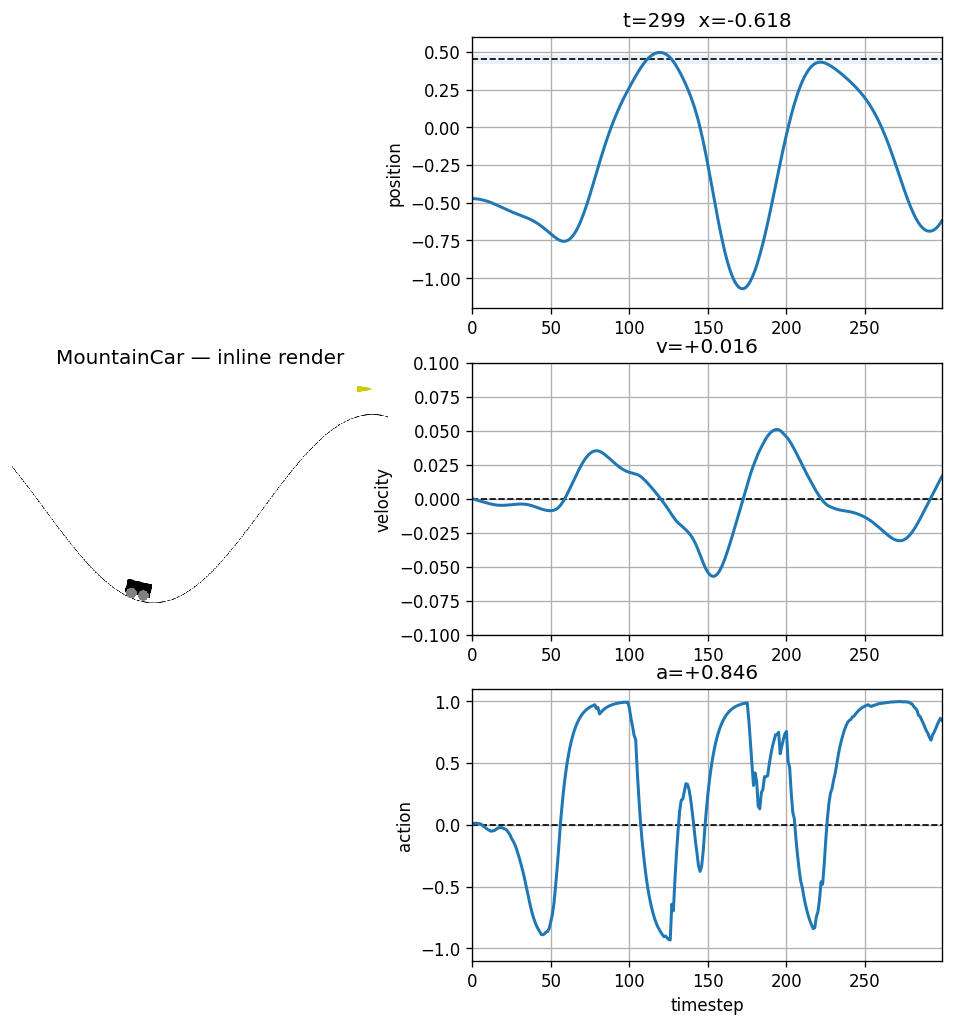

Finished. Steps=300 | Reached/held goal≈False | Return≈784.95


In [313]:
# === Inline env render + live plots (frame + x/v/a) ===
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# ---- goal band params (reuse your values) ----
GOAL = 0.45
NEAR_EPS = 0.03

# ---- make env with rgb frames for inline imshow ----
base_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
env = HoldAtSetpointWrapper(base_env, x_star=GOAL, pos_tol=0.008, v_tol=0.003, hold_steps=12)
obs, _ = env.reset(seed=0)

# ---- controller (uses your GP_MPPI that calls dyn.step_batch) ----
USE_STOCHASTIC_GP = False  # steadier holding near goal
# keep your trained GP adapter:
# dyn = SVGPDynamics(model, likelihood, X_mu, X_std, Y_mu, Y_std, device=device)

# Instantiate the MPPI controller with our GP dynamics
ctrl = GP_MPPI(
    horizon=40, n_samples=2048,
    lambda_=8.0, u_sigma=0.6,
    action_low=-1.0, action_high=1.0,
    sample_gp=False, seed=0, warm_start=True,
    smooth_weight=0.25, dynamics_adapter=dyn,
    rho_time=0.995, elite_frac=0.10, k_var=0.0, exec_beta=0.85,
    overshoot_guard=0.02, reach_bonus=4.0
)





# ---- figure: left = env frame, right = x/v/a time series ----
fig = plt.figure(figsize=(10, 10), dpi=120)
gs  = fig.add_gridspec(nrows=3, ncols=2, width_ratios=[1.2, 1.5], height_ratios=[1,1,1])

ax_img = fig.add_subplot(gs[:, 0])       # spans all rows
ax_x   = fig.add_subplot(gs[0, 1])
ax_v   = fig.add_subplot(gs[1, 1])
ax_a   = fig.add_subplot(gs[2, 1])

frame0 = env.render()
im = ax_img.imshow(frame0, interpolation="nearest")
ax_img.set_axis_off()
ax_img.set_title("MountainCar — inline render")

# goal band and lines
ax_x.axhspan(GOAL-NEAR_EPS, GOAL+NEAR_EPS, alpha=0.10)
ax_x.axhline(GOAL, ls="--", lw=1, c="k")
ax_v.axhline(0.0,   ls="--", lw=1, c="k")
ax_a.axhline(0.0,   ls="--", lw=1, c="k")

line_x, = ax_x.plot([], [], lw=1.8)
line_v, = ax_v.plot([], [], lw=1.8)
line_a, = ax_a.plot([], [], lw=1.8)
ax_x.set_ylabel("position")
ax_v.set_ylabel("velocity")
ax_a.set_ylabel("action"); ax_a.set_xlabel("timestep")
for ax in (ax_x, ax_v, ax_a):
    ax.grid(True)

display(fig)

# ---- rollout loop ----
t_hist, x_hist, v_hist, a_hist, r_hist = [], [], [], [], []
done, t, TMAX = False, 0, 300

buf = []

while not done and t < TMAX:
    p, v = float(obs[0]), float(obs[1])
    a_val = float(ctrl.plan((p, v)))
    nxt, r, term, trunc, _ = env.step([a_val])
    #done = term or trunc

    # update histories
    t_hist.append(t); x_hist.append(p); v_hist.append(v); a_hist.append(a_val); r_hist.append(r)
    t_arr = np.asarray(t_hist)

    # update plots
    line_x.set_data(t_arr, np.asarray(x_hist))
    line_v.set_data(t_arr, np.asarray(v_hist))
    line_a.set_data(t_arr, np.asarray(a_hist))

    # axes limits
    ax_x.set_xlim(0, max(50, t))
    ax_x.set_ylim(-1.2, 0.6)
    ax_v.set_xlim(0, max(50, t))   # keep same time window as position
    ax_v.set_ylim(-0.1, 0.1)
    ax_a.set_xlim(0, max(50, t))
    ax_a.set_ylim(-1.1, 1.1)

    # (optional) force x autoscale refresh
    for ax in (ax_v, ax_a):
        ax.relim()
        ax.autoscale_view(scalex=True, scaley=False)

    # update env frame
    im.set_data(env.render())
    ax_x.set_title(f"t={t}  x={p:+.3f}")
    ax_v.set_title(f"v={v:+.3f}")
    ax_a.set_title(f"a={a_val:+.3f}")

    clear_output(wait=True); display(fig); plt.pause(0.001)

    buf.append((obs[0], obs[1], a_val, nxt[0]-obs[0], nxt[1]-obs[1]))

    obs = nxt

    if len(buf) >= 298:                           # periodic flush
        P,V,A,DP,DV = map(np.array, zip(*buf))
        save_mc_dataset("mc_online_append.npz", P,V,A,DP,DV, meta={"source":"mppi"})
        buf.clear()

    t += 1

env.close(); plt.close(fig)

traj = np.column_stack([t_hist, x_hist, v_hist, a_hist, r_hist]).astype(np.float32)
print(f"Finished. Steps={len(traj)} | Reached/held goal≈{done} | Return≈{traj[:,4].sum():.2f}")